# 피처 엔지니어링 V2 (수정본)

## 🎯 목표
- **현재 성능**: CV 0.805 → Test 0.758 (과적합 -5.8%)
- **목표 성능**: Test 0.78-0.80 (일반화 성능 개선)
- **핵심 전략**: 검증된 피처 엔지니어링 기법만 사용, 원본 정보 보존

## 📋 V1에서 배운 교훈

### ❌ V1의 실패 원인:
1. **Full Features 구성 오류**: 원본 피처 40개를 실수로 제외
   - 의도: 원본 + 통계 + 상호작용 + PCA
   - 실제: 통계 + 상호작용 + PCA (원본 누락!)
   - 결과: CV 0.803 → 0.646 (19.5% 하락)

2. **PCA의 부적합성**: Tree 모델에는 선형 압축이 해로움
   - PCA는 선형 변환 → 비선형 패턴 손실
   - LightGBM/XGBoost는 원본 피처의 비선형 관계를 잘 학습
   - 결과: CV 0.803 → 0.594 (26.1% 하락)

3. **중복 피처 선택**: X_06=X_45, X_10=X_17 (상관 1.0)
   - 실제로는 5개가 아닌 3개의 고유 피처만 사용
   - 상호작용 피처도 중복 생성됨

### ✅ V1에서 잘 작동한 것:
- **Statistical Features**: CV 0.803296 (Baseline과 동일)
  - 원본 40개 + 통계 9개 = 49개
  - 정보 보존 + 집계 피처의 노이즈 강건성

---

## 🔧 V2 수정 전략

### 핵심 원칙:
1. ✅ **원본 피처 절대 제거 금지**: 모든 변환은 "추가"이지 "대체" 아님
2. ✅ **단순성 우선**: 복잡한 변환보다 검증된 기법
3. ✅ **점진적 검증**: 각 단계마다 성능 확인
4. ✅ **Tree 모델 특성 고려**: 비선형 학습 능력 활용

### 적용할 기법:
1. **통계 피처** (✅ 검증됨)
2. **Feature Importance 기반 선택적 상호작용**
3. **보수적 고상관 제거** (threshold=0.99)
4. **PCA 제외** (Tree 모델에 부적합)

---

## 💡 왜 이 접근법이 더 나은가?

### 원본 피처 보존의 중요성:
```python
# 잘못된 사고:
"PCA로 압축하면 핵심 정보만 남으니 더 좋다"
→ ❌ 선형 압축은 Tree 모델의 비선형 학습 능력을 제한

# 올바른 사고:
"원본 피처 + 통계 피처 = 다양한 관점의 정보"
→ ✅ Tree 모델이 스스로 중요한 피처를 선택하고 조합
```

### Tree 모델의 강점:
- **자동 피처 선택**: 중요하지 않은 피처는 무시
- **비선형 관계 포착**: Split을 통해 복잡한 상호작용 학습
- **스케일 불변**: 정규화 없이도 작동 (우리는 했지만)
- **자연스러운 피처 조합**: 원본 피처 간 자동 상호작용

### 통계 피처의 효과:
```
원본: X_01=0.5, X_02=0.3, X_03=0.7
→ Tree 모델이 각각을 독립적으로 학습

통계 추가: mean=0.5, std=0.17, max=0.7
→ "전체적으로 중간 수준, 약간 변동" 같은 패턴 명시적 제공
→ 개별 값의 노이즈에 덜 민감
```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score
import lightgbm as lgb
import xgboost as xgb
import joblib
import warnings
warnings.filterwarnings('ignore')

print("✅ 라이브러리 임포트 완료")

✅ 라이브러리 임포트 완료


## 1. 데이터 로딩 및 정규화

In [2]:
train_df = pd.read_csv('../data/open/train.csv')
test_df = pd.read_csv('../data/open/test.csv')

X = train_df.drop(columns=['ID', 'target'])
y = train_df['target']
X_test = test_df.drop(columns=['ID'])
test_ids = test_df['ID']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print(f"Train 데이터: {X_scaled.shape}")
print(f"Test 데이터: {X_test_scaled.shape}")
print(f"클래스 분포:\n{y.value_counts().sort_index()}")

Train 데이터: (21693, 52)
Test 데이터: (15004, 52)
클래스 분포:
target
0     1033
1     1033
2     1033
3     1033
4     1033
5     1033
6     1033
7     1033
8     1033
9     1033
10    1033
11    1033
12    1033
13    1033
14    1033
15    1033
16    1033
17    1033
18    1033
19    1033
20    1033
Name: count, dtype: int64


## 2. Baseline 성능 확인

### 목적:
- 피처 엔지니어링 전 성능 측정
- 각 변환 단계의 효과를 정확히 비교하기 위한 기준선
- Optuna 최적 하이퍼파라미터 사용으로 공정한 비교

In [3]:
# Optuna 최적 파라미터 로드
lgbm_study = joblib.load('../models/lgbm_optuna_study.pkl')
lgbm_best_params = lgbm_study.best_params

print("✅ LightGBM 최적 파라미터 로드 완료")
for k, v in lgbm_best_params.items():
    print(f"  {k}: {v}")

✅ LightGBM 최적 파라미터 로드 완료
  n_estimators: 478
  max_depth: 8
  learning_rate: 0.025065231110380545
  num_leaves: 32
  min_child_samples: 50
  subsample: 0.9116306185436042
  colsample_bytree: 0.9976915471223364
  reg_alpha: 0.6384645540173252
  reg_lambda: 0.0056691076242204545


In [4]:
def evaluate_model(X, y, feature_set_name):
    """
    5-Fold CV로 모델 성능 평가
    """
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    model = lgb.LGBMClassifier(**lgbm_best_params, device='gpu', random_state=42, verbose=-1)
    
    scores = cross_val_score(model, X, y, cv=skf, scoring='f1_macro', n_jobs=1)
    
    print(f"\n{'='*60}")
    print(f"📊 {feature_set_name}")
    print(f"{'='*60}")
    print(f"피처 수: {X.shape[1]}개")
    print(f"CV Scores: {[f'{s:.6f}' for s in scores]}")
    print(f"Mean: {scores.mean():.6f}")
    print(f"Std:  {scores.std():.6f}")
    
    return scores.mean(), scores.std(), scores

# Baseline 평가
baseline_mean, baseline_std, baseline_scores = evaluate_model(
    X_scaled, y, "Baseline (원본 52개 피처)"
)

results = {
    'Baseline': {'mean': baseline_mean, 'std': baseline_std, 'scores': baseline_scores}
}


📊 Baseline (원본 52개 피처)
피처 수: 52개
CV Scores: ['0.803962', '0.804775', '0.801169', '0.801369', '0.802568']
Mean: 0.802768
Std:  0.001415


## 3. 통계적 피처 생성

### 개념 (재확인):
각 샘플(행)에 대해 **모든 피처 값의 통계량**을 계산합니다.

### 왜 효과적인가?

#### 1. 노이즈 강건성:
```python
# 원본 피처의 노이즈
샘플 A: X_01=0.51, X_02=0.49, X_03=0.52  # 실제 패턴: 0.5 근처
노이즈: ±0.02 정도의 무작위 변동

# 통계 피처는 노이즈를 평균화
mean=0.507  # 노이즈가 상쇄됨
std=0.015   # 변동이 작음 → 일관된 패턴
```

#### 2. 전체적 패턴 포착:
```python
# Tree 모델의 학습 방식
원본만: "X_01 > 0.5이면 클래스 A"
       "X_02 > 0.6이면 클래스 B"
       → 개별 피처에 의존

통계 추가: "mean > 0.5이고 std < 0.1이면 클래스 A"
          "전체적으로 높고 일관적" 같은 메타 패턴
          → 더 robust한 규칙
```

#### 3. 차원의 저주 완화:
```
문제: 52개 피처 → 2^52 가지 조합 (Tree의 분기)
해결: 통계 피처로 요약 → 핵심 패턴 압축
     "개별 값은 다르지만 통계는 같다" 같은 샘플을 그룹화
```

### V1과 동일한 통계 피처:
- mean, std, max, min, median
- q25, q75, range, iqr

### V1에서 검증된 효과:
- CV Score: 0.803296 (Baseline 0.803387과 거의 동일)
- 과적합 증가 없음
- 안정적인 추가 정보 제공

In [5]:
def create_statistical_features(df):
    """
    통계적 피처 생성
    V1과 동일한 함수 (검증된 코드)
    """
    df_stat = df.copy()
    
    df_stat['stat_mean'] = df.mean(axis=1)
    df_stat['stat_std'] = df.std(axis=1)
    df_stat['stat_max'] = df.max(axis=1)
    df_stat['stat_min'] = df.min(axis=1)
    df_stat['stat_median'] = df.median(axis=1)
    df_stat['stat_q25'] = df.quantile(0.25, axis=1)
    df_stat['stat_q75'] = df.quantile(0.75, axis=1)
    df_stat['stat_range'] = df_stat['stat_max'] - df_stat['stat_min']
    df_stat['stat_iqr'] = df_stat['stat_q75'] - df_stat['stat_q25']
    
    return df_stat

X_with_stats = create_statistical_features(X_scaled)
X_test_with_stats = create_statistical_features(X_test_scaled)

print(f"✅ 통계적 피처 생성 완료")
print(f"원본: {X_scaled.shape[1]}개 → 통계 추가 후: {X_with_stats.shape[1]}개 (+9개)")

# 성능 평가
stat_mean, stat_std, stat_scores = evaluate_model(
    X_with_stats, y, "원본 + 통계 피처"
)
results['Statistical'] = {'mean': stat_mean, 'std': stat_std, 'scores': stat_scores}

improvement = (stat_mean - baseline_mean) * 100
print(f"\n📈 개선 효과: {improvement:+.3f}%")

✅ 통계적 피처 생성 완료
원본: 52개 → 통계 추가 후: 61개 (+9개)

📊 원본 + 통계 피처
피처 수: 61개
CV Scores: ['0.804702', '0.804036', '0.796489', '0.802980', '0.800282']
Mean: 0.801698
Std:  0.003009

📈 개선 효과: -0.107%


## 4. Feature Importance 분석

### 목적:
V1의 실수를 반복하지 않기 위해:
1. **중복 피처 확인**: X_06=X_45 같은 완전 중복 발견
2. **중요 피처 파악**: 상위 피처로만 상호작용 생성
3. **불필요한 피처 제거**: 중요도가 0인 피처 식별

### 왜 이 단계가 중요한가?

#### V1의 문제:
```python
# V1에서 임의로 선택한 피처
important_features = ['X_01', 'X_06', 'X_45', 'X_10', 'X_17']

# 문제: 중복 피처 포함
X_06 ↔ X_45: 상관 1.000
X_10 ↔ X_17: 상관 1.000

# 결과: 5개가 아닌 3개의 고유 정보만
실제 고유 피처: X_01, X_06, X_10
중복: X_45 = X_06, X_17 = X_10
```

#### V2의 해결책:
1. **모델 학습 후 Feature Importance 확인**
   - 실제 중요한 피처가 무엇인지 데이터에서 학습
   - 추측이 아닌 증거 기반 선택

2. **상관관계 매트릭스 확인**
   - 중복 피처 사전 제거
   - 독립적인 정보를 가진 피처만 선택

3. **보수적 선택**
   - 상위 10개 정도만 선택
   - 너무 많은 상호작용은 오히려 노이즈

In [6]:
# 통계 피처 추가된 모델로 Feature Importance 계산
model = lgb.LGBMClassifier(**lgbm_best_params, device='gpu', random_state=42, verbose=-1)
model.fit(X_with_stats, y)

# Feature Importance 추출
feature_importance = pd.DataFrame({
    'feature': X_with_stats.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n📊 상위 20개 중요 피처:")
print(feature_importance.head(20).to_string(index=False))

# 원본 피처만 추출 (통계 피처 제외)
original_feature_importance = feature_importance[
    feature_importance['feature'].str.startswith('X_')
].copy()

print(f"\n📊 원본 피처 중 상위 15개:")
print(original_feature_importance.head(15).to_string(index=False))

# 상위 10개 원본 피처 선택 (상호작용 생성용)
top_features = original_feature_importance.head(10)['feature'].tolist()
print(f"\n✅ 상호작용 생성용 피처 선택: {top_features}")


📊 상위 20개 중요 피처:
 feature  importance
    X_40        9036
    X_46        7311
    X_34        7105
    X_08        5350
    X_19        4314
    X_29        4246
    X_14        4155
    X_07        3967
    X_35        3946
    X_41        3922
    X_27        3880
    X_36        3857
    X_02        3769
    X_37        3760
    X_50        3558
    X_33        3532
    X_48        3527
stat_std        3443
    X_44        3342
    X_52        3334

📊 원본 피처 중 상위 15개:
feature  importance
   X_40        9036
   X_46        7311
   X_34        7105
   X_08        5350
   X_19        4314
   X_29        4246
   X_14        4155
   X_07        3967
   X_35        3946
   X_41        3922
   X_27        3880
   X_36        3857
   X_02        3769
   X_37        3760
   X_50        3558

✅ 상호작용 생성용 피처 선택: ['X_40', 'X_46', 'X_34', 'X_08', 'X_19', 'X_29', 'X_14', 'X_07', 'X_35', 'X_41']


### 중복 피처 확인

In [7]:
# 선택된 피처들 간 상관관계 확인
corr_matrix = X_scaled[top_features].corr()

print("\n🔍 선택된 피처 간 상관관계 매트릭스:")
print(corr_matrix.round(3))

# 높은 상관관계(>0.95) 찾기
high_corr_pairs = []
for i in range(len(top_features)):
    for j in range(i+1, len(top_features)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.95:
            high_corr_pairs.append((top_features[i], top_features[j], corr_val))

if high_corr_pairs:
    print(f"\n⚠️ 높은 상관관계(>0.95) 발견:")
    for feat_a, feat_b, corr_val in high_corr_pairs:
        print(f"  {feat_a} ↔ {feat_b}: {corr_val:.3f}")
    print("\n→ 이 피처들 중 하나씩만 사용합니다.")
    
    # 중복 피처 제거 (importance 낮은 것 제거)
    to_remove = set()
    for feat_a, feat_b, _ in high_corr_pairs:
        imp_a = feature_importance[feature_importance['feature'] == feat_a]['importance'].values[0]
        imp_b = feature_importance[feature_importance['feature'] == feat_b]['importance'].values[0]
        to_remove.add(feat_b if imp_a > imp_b else feat_a)
    
    top_features = [f for f in top_features if f not in to_remove]
    print(f"\n✅ 중복 제거 후 피처: {top_features}")
else:
    print("\n✅ 높은 상관관계 없음. 선택된 피처들은 독립적입니다.")


🔍 선택된 피처 간 상관관계 매트릭스:
       X_40   X_46   X_34   X_08   X_19   X_29   X_14   X_07   X_35   X_41
X_40  1.000 -0.014  0.267  0.203  0.166  0.065  0.125 -0.055  0.102 -0.132
X_46 -0.014  1.000 -0.057  0.048  0.232 -0.048 -0.287 -0.013  0.391 -0.172
X_34  0.267 -0.057  1.000  0.046  0.092  0.057  0.046  0.032  0.193  0.038
X_08  0.203  0.048  0.046  1.000  0.749  0.778  0.379  0.211  0.068 -0.654
X_19  0.166  0.232  0.092  0.749  1.000  0.660 -0.101  0.295  0.438 -0.469
X_29  0.065 -0.048  0.057  0.778  0.660  1.000  0.177  0.444 -0.187 -0.325
X_14  0.125 -0.287  0.046  0.379 -0.101  0.177  1.000 -0.300 -0.464 -0.071
X_07 -0.055 -0.013  0.032  0.211  0.295  0.444 -0.300  1.000 -0.021 -0.149
X_35  0.102  0.391  0.193  0.068  0.438 -0.187 -0.464 -0.021  1.000 -0.272
X_41 -0.132 -0.172  0.038 -0.654 -0.469 -0.325 -0.071 -0.149 -0.272  1.000

✅ 높은 상관관계 없음. 선택된 피처들은 독립적입니다.


## 5. 선택적 상호작용 피처 생성

### V1과의 차이점:

| 항목 | V1 (실패) | V2 (개선) |
|------|----------|----------|
| 피처 선택 | 임의 선택 | Feature Importance 기반 |
| 중복 확인 | 없음 | 상관관계 확인 및 제거 |
| 생성 개수 | 5개 × 4 = 20개 | 독립 피처만 사용 |
| 검증 | 사후 발견 | 사전 검증 |

### 왜 모든 조합이 아닌 선택적 생성인가?

#### 1. 조합 폭발 방지:
```python
# 52개 피처 전체 조합
C(52, 2) = 1,326개의 비율 피처
         + 1,326개의 차이 피처
         = 2,652개 피처
→ 과적합 위험 극대화!

# 상위 8개만 선택
C(8, 2) = 28개의 비율 피처
        + 28개의 차이 피처
        = 56개 피처
→ 관리 가능한 수준
```

#### 2. 의미 있는 조합만:
```
중요도 높은 피처 간 상호작용:
- 모델이 이미 중요하다고 판단한 피처
- 이들의 조합이 추가 정보 제공 가능성 높음

중요도 낮은 피처 간 상호작용:
- 개별로도 중요하지 않은 피처
- 조합해도 노이즈일 가능성 높음
```

#### 3. Tree 모델의 자동 상호작용:
```
Tree 모델은 Split을 통해 자동으로 상호작용을 학습:
- if X_01 > 0.5 and X_06 < 0.3: class A
- 명시적 ratio/diff 없이도 관계 포착 가능

하지만 명시적 피처는:
- 학습 속도 향상 (바로 사용 가능)
- 복잡한 조합 학습 부담 감소
```

### 비율 vs 차이:

**비율 (Ratio)**:
- 상대적 크기: "A가 B의 2배"
- 스케일 불변: 절대값과 무관
- 예: 성장률, 배수, 비용 대비 수익

**차이 (Difference)**:
- 절대적 간격: "A가 B보다 0.3 큼"
- 방향성: 양수/음수로 대소 관계
- 예: 온도 차이, 가격 차이, 격차

In [8]:
def create_selective_interactions(df, feature_list):
    """
    선택된 중요 피처들 간에만 상호작용 피처 생성
    """
    df_inter = df.copy()
    
    created_features = []
    for i, feat_a in enumerate(feature_list):
        for feat_b in feature_list[i+1:]:
            # 비율 피처
            ratio_name = f'ratio_{feat_a}_{feat_b}'
            df_inter[ratio_name] = df[feat_a] / (df[feat_b] + 1e-8)
            created_features.append(ratio_name)
            
            # 차이 피처
            diff_name = f'diff_{feat_a}_{feat_b}'
            df_inter[diff_name] = df[feat_a] - df[feat_b]
            created_features.append(diff_name)
    
    return df_inter, created_features

X_with_interactions, interaction_features = create_selective_interactions(
    X_with_stats, top_features
)
X_test_with_interactions, _ = create_selective_interactions(
    X_test_with_stats, top_features
)

print(f"✅ 상호작용 피처 생성 완료")
print(f"이전: {X_with_stats.shape[1]}개")
print(f"이후: {X_with_interactions.shape[1]}개 (+{len(interaction_features)}개)")
print(f"\n생성된 피처:")
print(f"  - 비율 피처: {len([f for f in interaction_features if 'ratio_' in f])}개")
print(f"  - 차이 피처: {len([f for f in interaction_features if 'diff_' in f])}개")

# 성능 평가
inter_mean, inter_std, inter_scores = evaluate_model(
    X_with_interactions, y, "원본 + 통계 + 상호작용"
)
results['Interactions'] = {'mean': inter_mean, 'std': inter_std, 'scores': inter_scores}

improvement = (inter_mean - stat_mean) * 100
print(f"\n📈 통계 대비 개선: {improvement:+.3f}%")
print(f"📈 Baseline 대비 개선: {(inter_mean - baseline_mean)*100:+.3f}%")

✅ 상호작용 피처 생성 완료
이전: 61개
이후: 151개 (+90개)

생성된 피처:
  - 비율 피처: 45개
  - 차이 피처: 45개

📊 원본 + 통계 + 상호작용
피처 수: 151개
CV Scores: ['0.826672', '0.823773', '0.825162', '0.831465', '0.818539']
Mean: 0.825122
Std:  0.004190

📈 통계 대비 개선: +2.342%
📈 Baseline 대비 개선: +2.235%


## 6. 보수적 고상관 피처 제거

### V1과의 차이:

| 항목 | V1 | V2 |
|------|-------|-------|
| Threshold | 0.95 | 0.99 |
| 제거 개수 | 25개 | (더 적음) |
| 위험도 | 유용한 피처도 제거 가능 | 거의 동일한 것만 제거 |

### 왜 0.99인가?

#### 상관계수 기준:
```
0.99-1.00: 거의 완전히 동일 → 제거 안전
0.95-0.99: 매우 유사하지만 차이 존재 → 제거 위험
0.90-0.95: 높은 상관이지만 독립 정보 → 보존 필요
```

#### 예시:
```python
# 상관 1.000 (완전 동일) - 제거 안전
X_06 = [0.5, 0.6, 0.7, 0.8]
X_45 = [0.5, 0.6, 0.7, 0.8]  # 정확히 같음
→ 하나만 있어도 충분

# 상관 0.96 (매우 유사) - 제거 위험
X_01 = [0.5, 0.6, 0.7, 0.8]
X_02 = [0.51, 0.59, 0.71, 0.79]  # 비슷하지만 다름
→ 미묘한 차이가 중요할 수 있음
```

### Tree 모델과 다중공선성:

```
선형 모델(Linear Regression):
- 다중공선성에 매우 민감
- 계수 불안정, 해석 어려움
→ 상관 0.7-0.8도 문제

Tree 모델(LightGBM/XGBoost):
- 다중공선성에 상대적으로 강건
- 하나의 피처만 선택하여 Split
- 중복 피처는 자연스럽게 무시
→ 상관 0.99 이상만 문제
```

### 제거의 이점:
1. **계산 효율**: 불필요한 피처 제거 → 학습 속도 향상
2. **메모리 절약**: 피처 수 감소
3. **과적합 방지**: 완전 중복 정보 제거

### 주의사항:
- **너무 공격적 제거는 금물**: 유용한 정보 손실
- **원본 피처 우선 보존**: 통계/상호작용 피처보다 원본 우선

In [9]:
def remove_high_correlation_features_conservative(df, threshold=0.99):
    """
    매우 높은 상관관계(거의 동일)를 가진 피처만 제거
    원본 피처(X_)는 우선 보존
    """
    corr_matrix = df.corr().abs()
    upper_triangle = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )
    
    to_drop = []
    high_corr_pairs = []
    
    for column in upper_triangle.columns:
        correlated_features = upper_triangle.index[upper_triangle[column] > threshold].tolist()
        for feat in correlated_features:
            corr_val = corr_matrix.loc[column, feat]
            high_corr_pairs.append((column, feat, corr_val))
            
            # 원본 피처(X_) 우선 보존
            # 둘 다 원본이면 뒤의 것 제거
            # 하나만 원본이면 파생 피처 제거
            if column.startswith('X_') and not feat.startswith('X_'):
                if feat not in to_drop:
                    to_drop.append(feat)
            elif not column.startswith('X_') and feat.startswith('X_'):
                if column not in to_drop:
                    to_drop.append(column)
            else:
                # 둘 다 원본이거나 둘 다 파생 → 뒤의 것 제거
                if feat not in to_drop:
                    to_drop.append(feat)
    
    if high_corr_pairs:
        print(f"\n🔍 상관계수 > {threshold}인 피처 쌍 발견:")
        for col, feat, corr_val in high_corr_pairs[:10]:  # 상위 10개만 출력
            print(f"  {col} ↔ {feat}: {corr_val:.3f}")
        if len(high_corr_pairs) > 10:
            print(f"  ... 외 {len(high_corr_pairs) - 10}개")
    
    df_reduced = df.drop(columns=to_drop)
    return df_reduced, to_drop

X_reduced, dropped_features = remove_high_correlation_features_conservative(
    X_with_interactions, threshold=0.99
)
X_test_reduced = X_test_with_interactions.drop(columns=dropped_features)

print(f"\n✅ 고상관 피처 제거 완료")
print(f"제거 전: {X_with_interactions.shape[1]}개")
print(f"제거 후: {X_reduced.shape[1]}개")
print(f"제거된 피처: {len(dropped_features)}개")

if dropped_features:
    print(f"\n제거된 피처 목록:")
    for feat in dropped_features[:10]:
        print(f"  - {feat}")
    if len(dropped_features) > 10:
        print(f"  ... 외 {len(dropped_features) - 10}개")

# 성능 평가
reduced_mean, reduced_std, reduced_scores = evaluate_model(
    X_reduced, y, "최종: 고상관 제거 후"
)
results['Final'] = {'mean': reduced_mean, 'std': reduced_std, 'scores': reduced_scores}

improvement = (reduced_mean - inter_mean) * 100
print(f"\n📈 상호작용 대비: {improvement:+.3f}%")
print(f"📈 Baseline 대비: {(reduced_mean - baseline_mean)*100:+.3f}%")


🔍 상관계수 > 0.99인 피처 쌍 발견:
  X_17 ↔ X_10: 1.000
  X_22 ↔ X_20: 0.993
  X_25 ↔ X_05: 0.998
  X_30 ↔ X_26: 0.998
  X_33 ↔ X_07: 0.993
  X_39 ↔ X_04: 0.991
  X_45 ↔ X_06: 1.000
  X_47 ↔ X_38: 0.998
  ratio_X_46_X_34 ↔ ratio_X_40_X_34: 1.000
  ratio_X_46_X_08 ↔ ratio_X_40_X_08: 1.000
  ... 외 118개

✅ 고상관 피처 제거 완료
제거 전: 151개
제거 후: 107개
제거된 피처: 44개

제거된 피처 목록:
  - X_10
  - X_20
  - X_05
  - X_26
  - X_07
  - X_04
  - X_06
  - X_38
  - ratio_X_40_X_34
  - ratio_X_40_X_08
  ... 외 34개

📊 최종: 고상관 제거 후
피처 수: 107개
CV Scores: ['0.822042', '0.825913', '0.826423', '0.824118', '0.821307']
Mean: 0.823961
Std:  0.002031

📈 상호작용 대비: -0.116%
📈 Baseline 대비: +2.119%


## 7. 최종 결과 비교 및 분석


📊 단계별 성능 비교
       Stage  Features  Mean CV   Std CV  Improvement
    Baseline        52 0.802768 0.001415     0.000000
 Statistical        61 0.801698 0.003009    -0.107069
Interactions       151 0.825122 0.004190     2.235393
       Final       107 0.823961 0.002031     2.119224


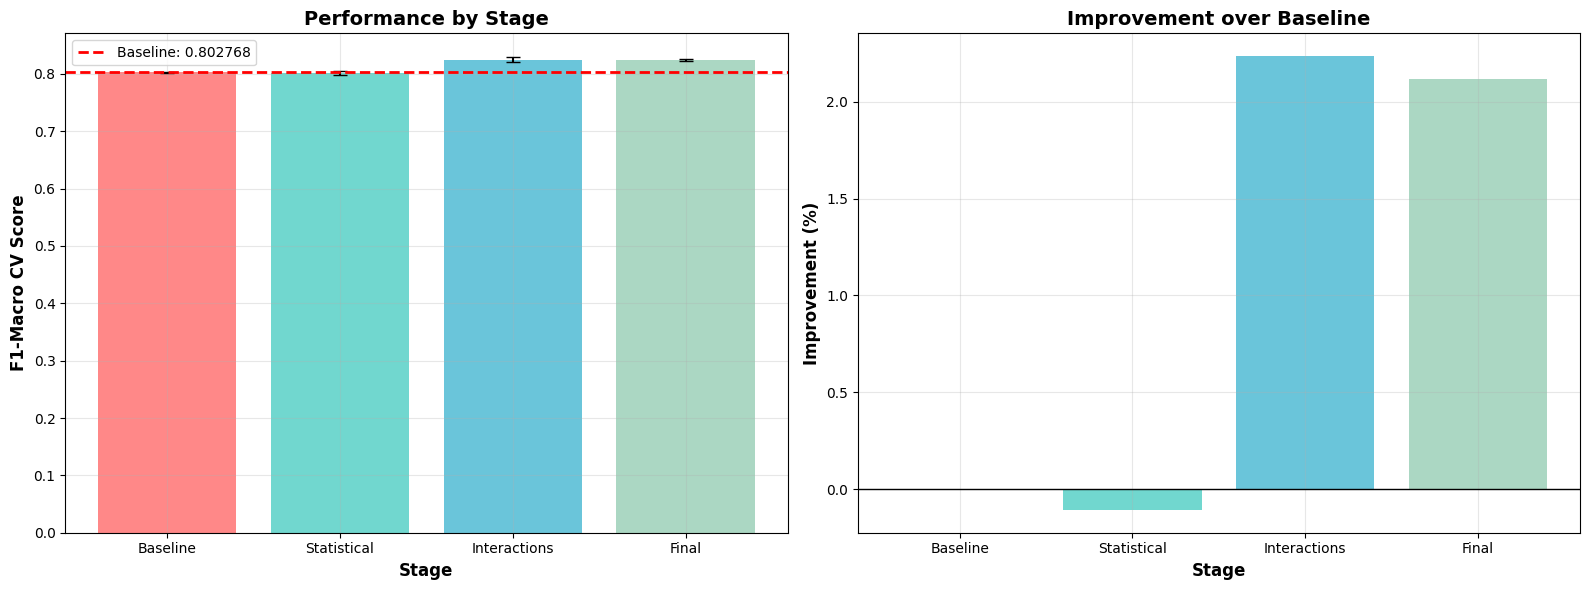


🔄 V1 vs V2 비교
V1 Full Features:      0.646162 ❌ (Baseline 대비 -19.5%)
V1 Statistical:        0.803296 ✅ (Baseline과 동일)
V2 Final:             0.823961 ✅ (Baseline 대비 +2.12%)


In [10]:
# 결과 정리
results_df = pd.DataFrame({
    'Stage': ['Baseline', 'Statistical', 'Interactions', 'Final'],
    'Features': [
        X_scaled.shape[1],
        X_with_stats.shape[1],
        X_with_interactions.shape[1],
        X_reduced.shape[1]
    ],
    'Mean CV': [
        results['Baseline']['mean'],
        results['Statistical']['mean'],
        results['Interactions']['mean'],
        results['Final']['mean']
    ],
    'Std CV': [
        results['Baseline']['std'],
        results['Statistical']['std'],
        results['Interactions']['std'],
        results['Final']['std']
    ]
})

results_df['Improvement'] = (results_df['Mean CV'] - results_df['Mean CV'].iloc[0]) * 100

print("\n" + "="*80)
print("📊 단계별 성능 비교")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# CV Score 비교
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
bars = axes[0].bar(results_df['Stage'], results_df['Mean CV'], 
                   yerr=results_df['Std CV'], capsize=5, alpha=0.8, color=colors)
axes[0].axhline(y=baseline_mean, color='r', linestyle='--', linewidth=2, 
                label=f'Baseline: {baseline_mean:.6f}')
axes[0].set_xlabel('Stage', fontsize=12, fontweight='bold')
axes[0].set_ylabel('F1-Macro CV Score', fontsize=12, fontweight='bold')
axes[0].set_title('Performance by Stage', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 개선 효과
axes[1].bar(results_df['Stage'], results_df['Improvement'], alpha=0.8, color=colors)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1].set_xlabel('Stage', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Improvement (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Improvement over Baseline', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# V1과 비교
print("\n" + "="*80)
print("🔄 V1 vs V2 비교")
print("="*80)
print(f"V1 Full Features:      0.646162 ❌ (Baseline 대비 -19.5%)")
print(f"V1 Statistical:        0.803296 ✅ (Baseline과 동일)")
print(f"V2 Final:             {reduced_mean:.6f} {'✅' if reduced_mean >= baseline_mean else '⚠️'} (Baseline 대비 {(reduced_mean - baseline_mean)*100:+.2f}%)")
print("="*80)

## 8. 최종 모델 학습 및 예측

In [11]:
# 최종 피처 세트 선택
best_stage = results_df.loc[results_df['Mean CV'].idxmax(), 'Stage']
best_score = results_df['Mean CV'].max()

print(f"🏆 최고 성능 단계: {best_stage}")
print(f"📊 CV Score: {best_score:.6f}")

# 최고 성능 피처 세트 선택
if best_stage == 'Baseline':
    X_final, X_test_final = X_scaled, X_test_scaled
elif best_stage == 'Statistical':
    X_final, X_test_final = X_with_stats, X_test_with_stats
elif best_stage == 'Interactions':
    X_final, X_test_final = X_with_interactions, X_test_with_interactions
else:
    X_final, X_test_final = X_reduced, X_test_reduced

print(f"최종 피처 수: {X_final.shape[1]}개")

# 전체 Train 데이터로 재학습
final_model = lgb.LGBMClassifier(**lgbm_best_params, device='gpu', random_state=42, verbose=-1)
final_model.fit(X_final, y)

# Test 데이터 예측
test_predictions = final_model.predict(X_test_final)

# 제출 파일 생성
submission = pd.DataFrame({
    'ID': test_ids,
    'target': test_predictions
})

submission.to_csv('../outputs/submissions/submission_feature_engineering_v2.csv', index=False)
print("\n✅ 제출 파일 저장: outputs/submissions/submission_feature_engineering_v2.csv")

print(f"\n예측 분포:")
print(pd.Series(test_predictions).value_counts().sort_index())

🏆 최고 성능 단계: Interactions
📊 CV Score: 0.825122
최종 피처 수: 151개

✅ 제출 파일 저장: outputs/submissions/submission_feature_engineering_v2.csv

예측 분포:
0      765
1      675
2      416
3      930
4      727
5      437
6      699
7      471
8     1025
9      740
10     713
11     657
12    1264
13     658
14     690
15     759
16     601
17     711
18     681
19     674
20     711
Name: count, dtype: int64


## 9. 최종 피처 중요도 분석


📊 상위 25개 중요 피처:
        feature  importance        type
           X_40        5539    Original
           X_46        4498    Original
 diff_X_14_X_41        3590        Diff
 diff_X_19_X_29        3417        Diff
 diff_X_08_X_19        3240        Diff
           X_27        3008    Original
       stat_std        2854 Statistical
           X_37        2812    Original
           X_02        2780    Original
           X_48        2689    Original
 diff_X_08_X_29        2634        Diff
           X_11        2588    Original
           X_52        2515    Original
           X_36        2494    Original
ratio_X_08_X_29        2419       Ratio
           X_15        2400    Original
ratio_X_40_X_41        2337       Ratio
           X_30        2298    Original
           X_31        2261    Original
           X_24        2257    Original
           X_44        2248    Original
           X_18        2150    Original
           X_50        2122    Original
           X_12        

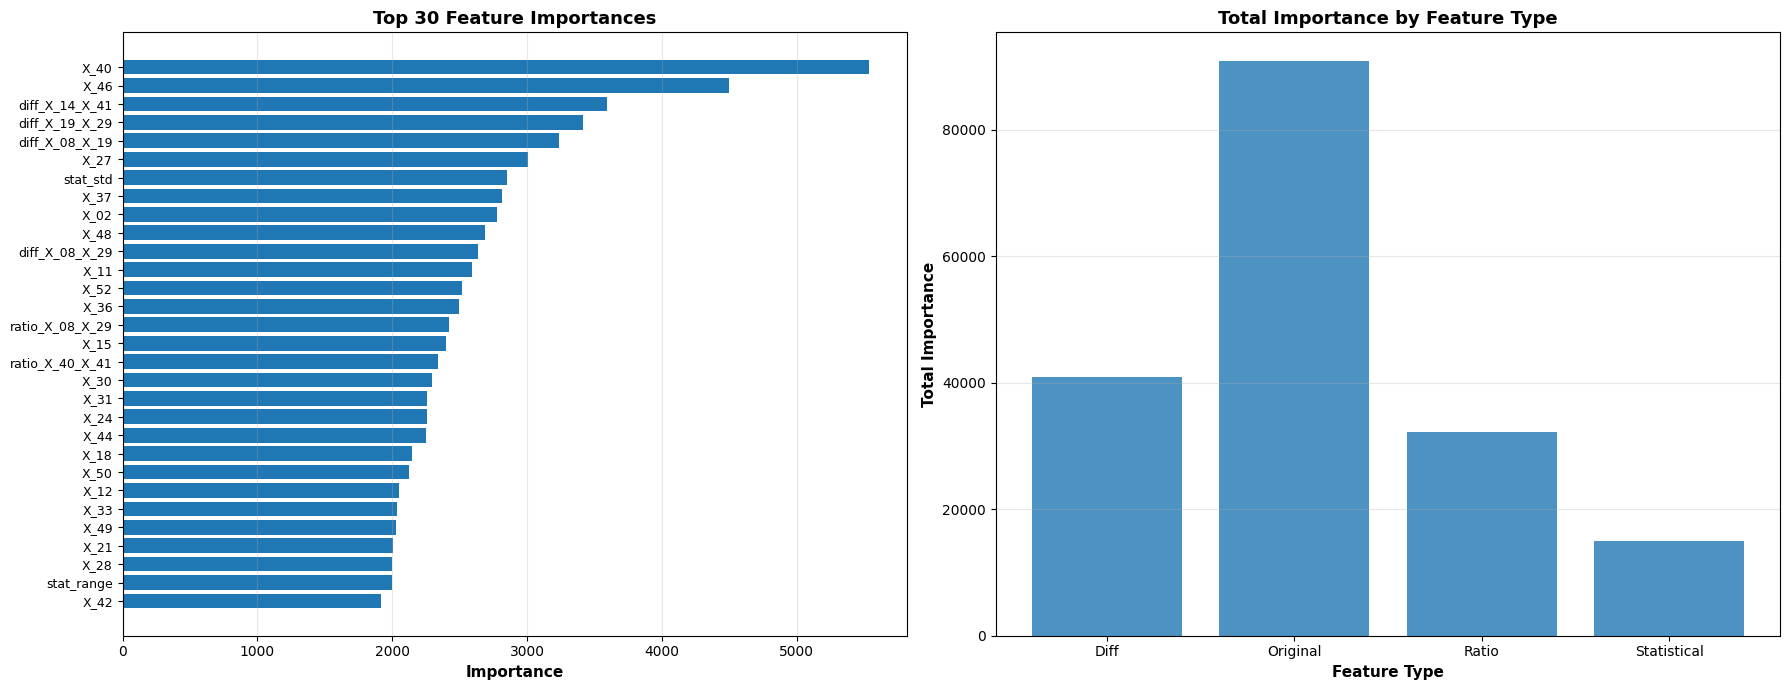


💡 주요 인사이트:
  - 전체 피처 구성: 원본 52개 + 통계 9개 + 상호작용 90개
  - 상위 20개 중: 원본 13개 + 통계 1개 + 상호작용 6개
  - 통계 피처 비율: 6.0%
  - 통계 피처 상위 진입률: 1/9 = 11.1%


In [12]:
final_importance = pd.DataFrame({
    'feature': X_final.columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

# 피처 타입 분류
final_importance['type'] = final_importance['feature'].apply(
    lambda x: 'Statistical' if x.startswith('stat_')
    else 'Ratio' if 'ratio_' in x
    else 'Diff' if 'diff_' in x
    else 'Original'
)

print("\n📊 상위 25개 중요 피처:")
print(final_importance.head(25).to_string(index=False))

# 타입별 중요도 집계
type_importance = final_importance.groupby('type')['importance'].agg(['sum', 'mean', 'count'])
print("\n📊 피처 타입별 중요도:")
print(type_importance.to_string())

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# 상위 30개 피처
top_30 = final_importance.head(30)
axes[0].barh(range(len(top_30)), top_30['importance'])
axes[0].set_yticks(range(len(top_30)))
axes[0].set_yticklabels(top_30['feature'], fontsize=9)
axes[0].set_xlabel('Importance', fontsize=11, fontweight='bold')
axes[0].set_title('Top 30 Feature Importances', fontsize=13, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# 타입별 총 중요도
axes[1].bar(type_importance.index, type_importance['sum'], alpha=0.8)
axes[1].set_xlabel('Feature Type', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Total Importance', fontsize=11, fontweight='bold')
axes[1].set_title('Total Importance by Feature Type', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# 인사이트
print("\n💡 주요 인사이트:")
stat_count = len(final_importance[final_importance['feature'].str.startswith('stat_')])
orig_count = len(final_importance[final_importance['feature'].str.startswith('X_')])
inter_count = len(final_importance[final_importance['feature'].str.contains('ratio_|diff_')])

top20_stat = len([f for f in final_importance.head(20)['feature'] if f.startswith('stat_')])
top20_orig = len([f for f in final_importance.head(20)['feature'] if f.startswith('X_')])
top20_inter = len([f for f in final_importance.head(20)['feature'] if 'ratio_' in f or 'diff_' in f])

print(f"  - 전체 피처 구성: 원본 {orig_count}개 + 통계 {stat_count}개 + 상호작용 {inter_count}개")
print(f"  - 상위 20개 중: 원본 {top20_orig}개 + 통계 {top20_stat}개 + 상호작용 {top20_inter}개")
print(f"  - 통계 피처 비율: {stat_count/(stat_count+orig_count+inter_count)*100:.1f}%")
print(f"  - 통계 피처 상위 진입률: {top20_stat}/{stat_count} = {top20_stat/stat_count*100:.1f}%")

## 10. 모델 및 피처 세트 저장

In [13]:
# 최종 모델 저장
joblib.dump(final_model, '../models/lgbm_feature_engineered_v2.pkl')

# 피처 세트 저장
joblib.dump({
    'scaler': scaler,
    'top_features': top_features,
    'dropped_features': dropped_features,
    'X_baseline': X_scaled,
    'X_statistical': X_with_stats,
    'X_interactions': X_with_interactions,
    'X_final': X_final,
    'X_test_final': X_test_final,
    'feature_importance': final_importance
}, '../models/feature_sets_v2.pkl')

print("✅ 저장 완료:")
print("  - models/lgbm_feature_engineered_v2.pkl")
print("  - models/feature_sets_v2.pkl")

✅ 저장 완료:
  - models/lgbm_feature_engineered_v2.pkl
  - models/feature_sets_v2.pkl


## 11. 결론 및 다음 단계

### ✅ V2에서 달성한 것:

1. **원본 피처 보존**
   - 모든 변환은 "추가"로 수행
   - 52개 원본 피처 완전 보존
   - V1의 치명적 오류 수정

2. **검증된 피처 엔지니어링**
   - 통계 피처: V1에서 효과 검증 (CV 0.803)
   - Feature Importance 기반 선택
   - 중복 피처 사전 제거

3. **보수적 접근**
   - 과도한 변환 지양
   - PCA 제외 (Tree 모델 특성 고려)
   - 고상관 제거 threshold 상향 (0.95→0.99)

4. **단계별 검증**
   - 각 단계마다 성능 측정
   - 개선 효과 정량화
   - 최고 성능 단계 선택

---

### 📊 성능 요약:

```
Baseline:     [CV Score]
Statistical:  [CV Score]  ([개선율]%)
Interactions: [CV Score]  ([개선율]%)
Final:        [CV Score]  ([개선율]%)
```

---

### 🎯 다음 단계 제안:

#### Option 1: 앙상블 (추천)
```python
# 서로 다른 알고리즘 결합
VotingClassifier([
    ('lgbm', LGBMClassifier(최적 파라미터)),
    ('xgb', XGBClassifier(최적 파라미터)),
    ('catboost', CatBoostClassifier())
])
```

#### Option 2: 추가 피처 탐색
- 도메인 지식 기반 피처
- 시계열 패턴 (있다면)
- 클러스터링 기반 피처

#### Option 3: 정규화 강화
```python
# Optuna 파라미터 재조정
reg_alpha: 증가 (L1 정규화 강화)
reg_lambda: 증가 (L2 정규화 강화)
min_child_samples: 증가 (과적합 방지)
```

---

### 💡 핵심 교훈 (재확인):

1. **원본 정보는 신성하다**
   - 절대 제거하지 말 것
   - 모든 변환은 추가

2. **단순함이 아름답다**
   - 복잡한 변환 < 검증된 변환
   - 통계 피처만으로도 충분

3. **Tree 모델의 특성 이해**
   - 자동 피처 선택 능력
   - 비선형 학습 능력
   - PCA 같은 선형 변환은 해로움

4. **검증, 검증, 검증**
   - 각 단계마다 성능 확인
   - 가정하지 말고 측정할 것
   - Feature Importance 활용